# Data Collection

In [1]:
import json
import os
import numpy as np
import itertools

import networkx as nx
import cdlib

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

In [3]:
LOAD = True
OPINION = True

if LOAD:
    full_graph = nx.read_gexf(os.path.join("graph","full_network.gexf"))
    if OPINION: full_graph_backbone = nx.read_gexf(os.path.join("graph","full_network_backbone_opinion.gexf"))
    else: full_graph_backbone = nx.read_gexf(os.path.join("graph","full_network_backbone.gexf"))

## Costruzione Grafico completo

### Caricamento commenti e posts

In [3]:
# Funzione per caricare i commenti
def load_comments(file_path):
    """Carica i commenti e crea una lista con autore, parent_id e timestamp."""
    comments = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line.strip())
            if "author" in data and "parent_id" in data and "id" in data and "created_utc" in data:
                comments.append({
                    "author": data["author"],
                    "parent_id": data["parent_id"],  # ID del commento a cui risponde
                    "id": "t1_" + data["id"],  # Reddit usa prefissi "t1_" per commenti e "t3_" per post
                    "subreddit": data["subreddit"],
                    "ups": data["ups"],  # Upvotes
                    "downs": data["downs"],  # Downvotes
                    "created_utc": datetime.utcfromtimestamp(data["created_utc"])  # Data
                })
    return comments

# Funzione per caricare i post
def load_posts(file_path):
    """Carica i post e crea una lista con autore e timestamp."""
    posts = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line.strip())
            if "author" in data and "id" in data and "created_utc" in data:
                posts.append({
                    "author": data["author"],
                    "id": "t3_" + data["id"],  # Reddit usa prefissi "t1_" per commenti e "t3_" per post
                    "subreddit": data["subreddit"],
                    "ups": data["ups"],  # Upvotes
                    "downs": data["downs"],  # Downvotes
                    "created_utc": datetime.utcfromtimestamp(data["created_utc"])
                })
    return posts


**E' necessario inserire i prefissi t1_ e t3_** perché  ID dei commenti e dei post provengono da spazi di identificazione separati, è possibile (anche se raro) che un commento e un post abbiano lo stesso ID.

Inoltre, più importante, l'attributo "parent_id" viene fornito con t1_ o t3_, quindi per verificare che un parent_id sia tra i commenti (_if parent_id in comment_author_, oppure _if parent_id in post_author_) è necessario il prefisso per trovare gli ID uguali.

### Creazione del grafico

- Se un utente A risponde a un utente B, aggiunge un arco (A → B).
- Se lo stesso utente interagisce più volte, incrementa il peso dell'arco.

In [4]:
def build_graph(comments, posts):
    """Costruisce un grafo diretto pesato a partire dai commenti e post."""
    G = nx.DiGraph()  # Grafo diretto

    # Creare un dizionario {comment_id: author}
    post_author = {p["id"]: p["author"] for p in posts}  # ID post → autore
    comment_author = {c["id"]: c["author"] for c in comments}  # ID commento → autore
    #comment_author = {c["parent_id"]: c["author"] for c in comments}  # ID commento → autore

    for comment in comments:
        author = comment["author"]
        parent_id = comment["parent_id"]
        subreddit = comment["subreddit"]

        # Controlla se il commento risponde a un altro utente
        if parent_id in comment_author:
            parent_author = comment_author[parent_id]
        elif parent_id in post_author:
            parent_author = post_author[parent_id]
        else:
            continue  # Se il parent non è nei dati, ignora il commento

        if author != "[deleted]" and parent_author != "[deleted]":
            if G.has_edge(author, parent_author):
                G[author][parent_author]["weight"] += 1  # Incrementa il peso
            else:
                G.add_edge(author, parent_author, weight=1, subreddit=subreddit)  # Nuova connessione

    # Rimuove Self-Loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Rimuove Moderatori e Bot
    moderators_list = {"AutoModerator", "trump-ModTeam", "JoeBiden-ModTeam", "KamalaHarris-ModTeam"}  
    bots = {user for user in G.nodes if "bot" in user.lower()}

    G.remove_nodes_from(moderators_list | bots)  # Rimuove sia moderatori che bot

    return G

In __comment_author__ viene usato __"id"__ invece di __"parent_id"__, perché quest'ultimo rappresenta l'ID del commento o post a cui il commento sta rispondendo, mentre c["author"] è l'autore del commento.
Quindi, in caso di più commenti che rispondono allo stesso post o commento, il dizionario manterrà solo l'ultimo autore visto. Questo potrebbe causare errori nella costruzione del grafo.

In [28]:
# Per rivelare eventuali moderatori 
moderator = []
for comments in all_comments:
    if 'mod' in comments['author'].lower() and comments['author'] not in moderator:
        moderator.append(comments['author'])
moderator

In [5]:
def simplify_graph(G, min_degree):
    """Sfoltisce il grafo direzionale rimuovendo utenti poco attivi"""
    
    # Rimuove utenti con basso grado totale (in + out)
    degree = dict(G.degree())
    small_nodes = {node for node, deg in degree.items() if deg < min_degree}
    G.remove_nodes_from(small_nodes)

    # Dopo la semplificazioni posso rimanere dei nodi senza collegamento
    degree = dict(G.degree()) # Devo ricalcolare il nuovo degree
    zero_nodes = {node for node, deg in degree.items() if deg == 0}
    G.remove_nodes_from(zero_nodes)
    
    return G

### Costruzione grafico

Crea il grafo complessivo:

In [6]:
# Carica i post di tutti i subreddit
all_posts = []
all_comments = []
subreddits = ["trump", "JoeBiden", "KamalaHarris", "conservative", "Liberal", "democrats"]
for sub in subreddits:
    all_comments.extend(load_comments(os.path.join('data','json_data', f"r_{sub}_comments.jsonl")))
    all_posts.extend(load_posts(os.path.join('data','json_data', f"r_{sub}_posts.jsonl")))  

In [7]:
# Crea il grafo completo e aggiungere l'opinione
full_graph = build_graph(all_comments, all_posts)
full_graph = simplify_graph(full_graph, min_degree=2)

# Salva il grafo per Gephi
nx.write_gexf(full_graph, os.path.join("graph","full_network.gexf"))
print("✔️ Grafo completo salvato!")

✔️ Grafo completo salvato!


Proprietà base:

In [8]:
# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(full_graph.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(full_graph.edges(data=True), 5):
    print(edge)

Nodo AutomaticDrop6236: {}
Nodo Instr-FTO: {}
Nodo DW_Softwere_Guy: {}
Nodo calcastanos: {}
Nodo Western-Fix-170: {}


('Instr-FTO', 'AutomaticDrop6236', {'weight': 2, 'subreddit': 'trump'})
('Instr-FTO', 'Ok-Weakness3219', {'weight': 1, 'subreddit': 'trump'})
('Instr-FTO', 'AnakinTheBetrayer', {'weight': 1, 'subreddit': 'trump'})
('Instr-FTO', 'Sufficient-Cat-5399', {'weight': 2, 'subreddit': 'trump'})
('Instr-FTO', 'onearmedmonkey', {'weight': 2, 'subreddit': 'trump'})


In [9]:
# Numero di nodi e archi
print(f"Nodi: {full_graph.number_of_nodes()}, Archi: {full_graph.number_of_edges()}")

# Top 10 utenti più attivi (grado entrante e uscente)
in_degree = sorted(full_graph.in_degree, key=lambda x: x[1], reverse=True)[:10]
out_degree = sorted(full_graph.out_degree, key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 utenti con più risposte ricevute:")
for user, deg in in_degree:
    print(f"{user}: {deg} risposte")

print("\nTop 10 utenti che rispondono di più:")
for user, deg in out_degree:
    print(f"{user}: {deg} risposte date")

Nodi: 37336, Archi: 267561

Top 10 utenti con più risposte ricevute:
intelligentreviews: 2543 risposte
f1sh98: 2498 risposte
PotatoUmaru: 2263 risposte
Arachnohybrid: 1951 risposte
nimobo: 1849 risposte
Ask4MD: 1707 risposte
progress18: 1476 risposte
yuri_2022: 1385 risposte
thatrightwinger: 1137 risposte
Plus-Bluejay-2024: 1132 risposte

Top 10 utenti che rispondono di più:
harmier2: 821 risposte date
raistlin65: 682 risposte date
EntranceCrazy918: 568 risposte date
RainforestNerdNW: 527 risposte date
Freedom_Isnt_Free_76: 456 risposte date
sowellpatrol: 431 risposte date
AlexKingstonsGigolo: 393 risposte date
Arachnohybrid: 374 risposte date
Sleep_On_It43: 328 risposte date
zootayman: 320 risposte date


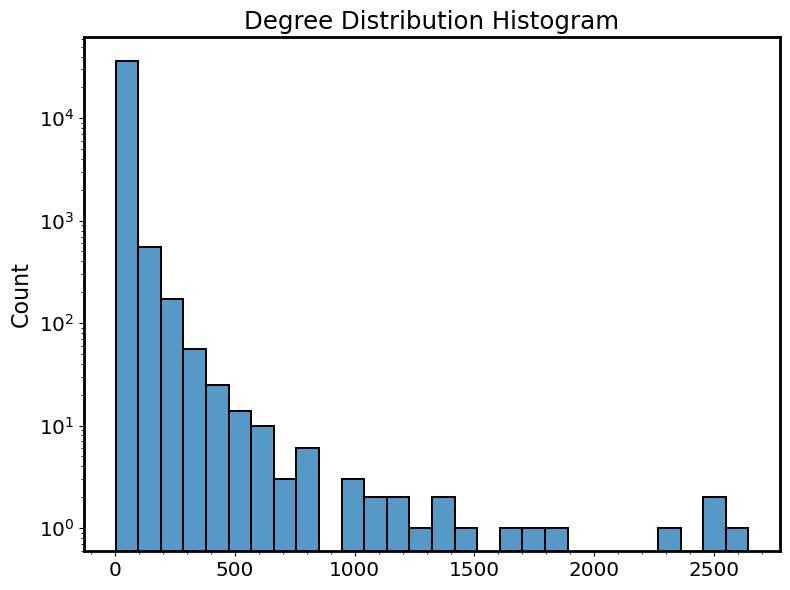

In [102]:
degree = [x[1] for x in full_graph.degree]
sns.histplot(np.asarray(degree), bins='doane', log=True)
plt.title("Degree Distribution Histogram")
plt.show()

#np.unique(np.asarray(degree), return_counts=True)

## Backboning

Il network contiene un quantità elevata di nodi e archi, è possibile diminuirla utilizzando uno dei metodi di **backbning**, in particolare scelgo **Disparity Filter** che si basa su un metodo statistico per selezionare gli archi che hanno una certa rilevanza.

Il file __backboning.py__ è stato preso dalla directory di github: https://github.com/sna-unipi/ANC-lectures-notebooks

### Costruzione grafico backbone

Prima di applicare l'algoritmo bisogna salvare il grafico in base alle richieste del file backboning.py:

    The input file should have three or more columns (default separator: tab).
    The input file must have a one line header with the column names.
    There must be two columns called 'src' and 'trg', indicating the origin and destination of the interaction.
    All other columns must contain integer or floats, indicating the edge weight.

In [22]:
import pandas as pd

def graph_to_csv(G, filename="graph.csv"):
    """
    Converte un grafo NetworkX in un file CSV con il formato richiesto.
    Il file avrà le colonne 'src' e 'trg' per le connessioni e una colonna 'w' per il peso degli archi.
    """
    
    # Creia una lista per memorizzare i dati degli archi
    data = []
    
    for u, v, attr in G.edges(data=True):
        row = {"src": u, "trg": v, "w": attr.get("weight", 1), 'sub': attr.get("subreddit")}  # Default weight = 1 se non presente
        data.append(row)
    
    # Creia un DataFrame
    df = pd.DataFrame(data)
    
    # Salvia in formato CSV con separatore TAB
    df.to_csv(os.path.join("data", filename), sep="\t", index=False)
    
    print(f"File salvato come {filename}")

In [23]:
graph_to_csv(full_graph, filename="full_graph.csv")

File salvato come full_graph.csv


Adesso possiamo eseguire l'algoritmo:

In [24]:
%%time

import backboning

table, nnodes, nnedges = backboning.read(os.path.join("data", "full_graph.csv"), "w", undirected=False, sep="\t")

df_table = backboning.disparity_filter(table)
df_backbone = backboning.thresholding(df_table, 0.6)
backboning.write(df_backbone, "backbone", "df", "data")

Calculating DF score...


CPU times: user 1.15 s, sys: 54.1 ms, total: 1.21 s
Wall time: 1.21 s


La formula del p-value misura la probabilità che un peso estratto casualmente sia maggiore o uguale a quello osservato. L'ipotesi nulla corrisponde ad una distribuzione uniforme dei pesi.

- Se il **p-value è basso**, significa che il peso osservato è improbabile sotto l'ipotesi nulla, quindi **l'arco è significativo** e viene mantenuto.
- Se il **p-value è alto**, significa che il peso potrebbe essere dovuto al caso, quindi **l'arco viene scartato**.

Il valore dello score corrisponde a 1-p_value: più è **alto lo score**, **più significativo è il legame**. Dunque la threshold del codice funziona in modo opposto al valore critico $\alpha$, se vogliamo aumentare il filtraggio dobbiamo aumentare la threshold (vengono scartati gli archi con score minore della threshold)

Estraiamo il nuovo grafico dal file csv creato:

In [25]:
def graph_from_csv(filename):
    g = nx.DiGraph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.rstrip().split("\t")
            g.add_edge(l[0], l[1], weight=float(l[2]), subreddit=l[3])
    return g

In [29]:
full_graph_backbone = graph_from_csv(os.path.join("data","backbone_df.csv"))

# Rinserisce l'attributo subreddit sugli archi
for u, v in full_graph_backbone.edges():
    if full_graph.has_edge(u, v):  # Controlla se l'edge esiste in full_graph
        full_graph_backbone[u][v]["subreddit"] = full_graph[u][v].get("subreddit", "unknown")

# Salva il grafo per Gephi
nx.write_gexf(full_graph_backbone, os.path.join("graph","full_network_backbone.gexf"))
print("✔️ Grafo completo salvato!")

✔️ Grafo completo salvato!


In [30]:
print("Before Backboning:")
print(f"Nodi: {full_graph.number_of_nodes()}, Archi: {full_graph.number_of_edges()}")

print("\nAfter Backboning:")
print(f"Nodi: {full_graph_backbone.number_of_nodes()}, Archi: {full_graph_backbone.number_of_edges()}")

Before Backboning:
Nodi: 37336, Archi: 267561

After Backboning:
Nodi: 18941, Archi: 72726


In [31]:
# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(full_graph_backbone.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(full_graph_backbone.edges(data=True), 5):
    print(edge)

Nodo Instr-FTO: {}
Nodo AutomaticDrop6236: {}
Nodo Sufficient-Cat-5399: {}
Nodo onearmedmonkey: {}
Nodo Captainmanic: {}


('Instr-FTO', 'AutomaticDrop6236', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'Sufficient-Cat-5399', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'onearmedmonkey', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'Captainmanic', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'Silent_Spell_3415', {'weight': 3.0, 'subreddit': 'trump'})


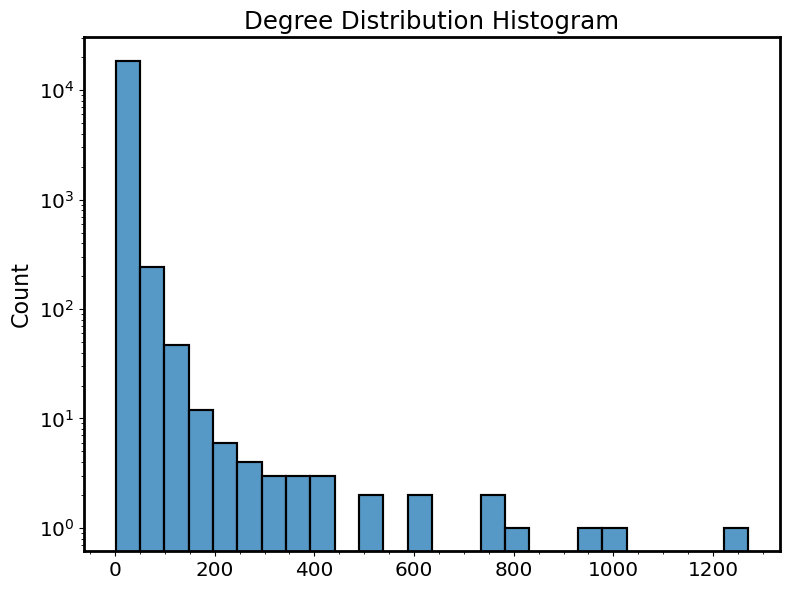

In [203]:
degree = [x[1] for x in full_graph_backbone.degree]
sns.histplot(np.asarray(degree), bins='doane', log=True)
plt.title("Degree Distribution Histogram")
plt.show()

#np.unique(np.asarray(degree), return_counts=True)

### Distribuzioni dopo backboning

Codici distribuzioni presi da: https://github.com/sna-unipi/ANC-lectures-notebooks/blob/main/Lab%204%20-%20Graph%20Sampling.ipynb
(i codici sono stati modificati)

In [4]:
def plot_degree_distribution(graph, graph_backbone, save=False):
    """
    Plot the degree distribution of a NetworkX graph in log-log scale.
    
    Parameters:
    - graph: NetworkX graph object
    """
    degrees = [graph.degree(node) for node in graph.nodes()]
    degree_counts = nx.degree_histogram(graph)

    degrees_backbone = [graph_backbone.degree(node) for node in graph_backbone.nodes()]
    degree_counts_backbone = nx.degree_histogram(graph_backbone)
    
    #plt.figure(figsize=(10, 6))
    plt.scatter(range(len(degree_counts)), degree_counts, edgecolor='black', linewidths=0.3, label='before backbone')
    plt.scatter(range(len(degree_counts_backbone)), degree_counts_backbone, color='coral', edgecolor='black', linewidths=0.3, label='after backbone')
   # plt.loglog(range(len(degree_counts)), degree_counts, 'b', marker='.')
    title = "Degree Distribution (Log-Log Scale)"
    plt.title(title)
    plt.loglog()
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    #plt.grid(True)
    if save: plt.savefig(os.path.join("images", title))
    plt.show()

def plot_degree_vs_clustering(graph, graph_backbone, save=False):
    """
    Plot a scatter plot of node degree vs local clustering coefficient for a NetworkX graph.
    
    Parameters:
    - graph: NetworkX graph object
    """
    degrees = dict(graph.degree())
    clustering = nx.clustering(graph)
    
    x = [degrees[node] for node in graph.nodes()]
    y = [clustering[node] for node in graph.nodes()]

    degrees_backbone = dict(graph_backbone.degree())
    clustering_backbone = nx.clustering(graph_backbone)

    x_backbone = [degrees_backbone[node] for node in graph_backbone.nodes()]
    y_backbone = [clustering_backbone[node] for node in graph_backbone.nodes()]
    
    #plt.figure(figsize=(10, 6))
    plt.scatter(x, y, marker='o', color='b', alpha=0.7, label='before backbone')
    plt.scatter(x_backbone, y_backbone, marker='o', color='coral', alpha=0.7, label='after backbone')
    title = "Node Degree vs Local Clustering Coefficient"
    plt.title(title)
    plt.xlabel("Node Degree")
    plt.ylabel("Local Clustering Coefficient")
    #plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(os.path.join("images", title))
    plt.show()

def plot_shortest_path_length_distribution(graph, graph_backbone, save=False):
    """
    Plot the distribution of shortest path lengths within the giant component of a NetworkX graph.
    
    Parameters:
    - graph: NetworkX graph object
    """
    graph = graph.copy().to_undirected()
    graph_backbone = graph_backbone.copy().to_undirected()

    # Get the largest connected component (giant component)
    largest_cc = max(nx.connected_components(graph), key=len)
    giant_component = graph.subgraph(largest_cc).copy()
    
    # Calculate shortest path lengths
    path_lengths = dict(nx.shortest_path_length(giant_component))
  
    
    # Flatten the dictionary of dictionaries into a list of path lengths
    all_lengths = []
    for source, paths in path_lengths.items():
        all_lengths.extend(paths.values())

    # Get the largest connected component (giant component)
    largest_cc_backbone = max(nx.connected_components(graph_backbone), key=len)
    giant_component_backbone = graph_backbone.subgraph(largest_cc_backbone).copy()
    
    
    # Calculate shortest path lengths
    path_lengths_backbone = dict(nx.shortest_path_length(giant_component_backbone))
  
    
    # Flatten the dictionary of dictionaries into a list of path lengths
    all_lengths_backbone = []
    for source, paths in path_lengths_backbone.items():
        all_lengths_backbone.extend(paths.values())
    
    # Plot histogram of shortest path lengths
    #plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=30, edgecolor='black', alpha=1, label='before backbone')
    plt.hist(all_lengths_backbone, bins=30, edgecolor='black', alpha=0.7, label='after backbone')
    title = 'Distribution of Shortest Path Lengths in Giant Component'
    plt.title(title)
    plt.xlabel('Shortest Path Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(os.path.join("images", title))
    plt.show()

    return all_lengths, all_lengths_backbone


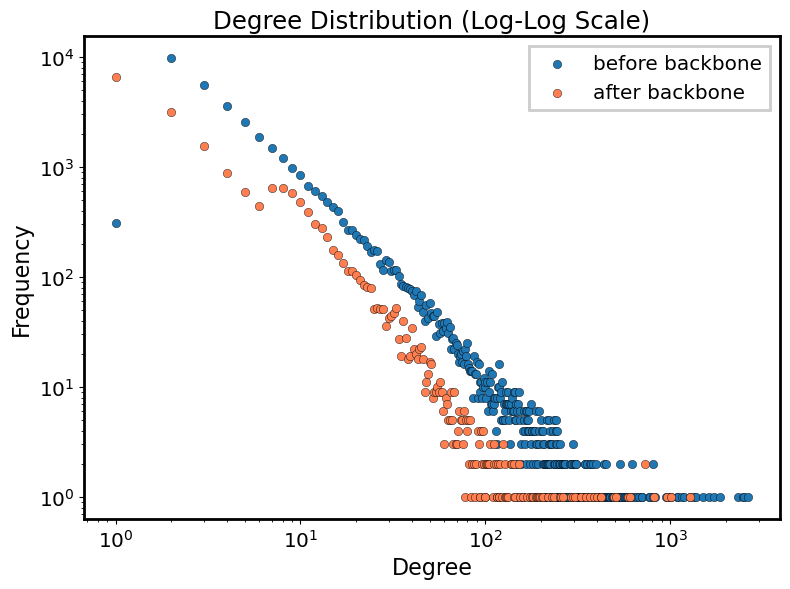

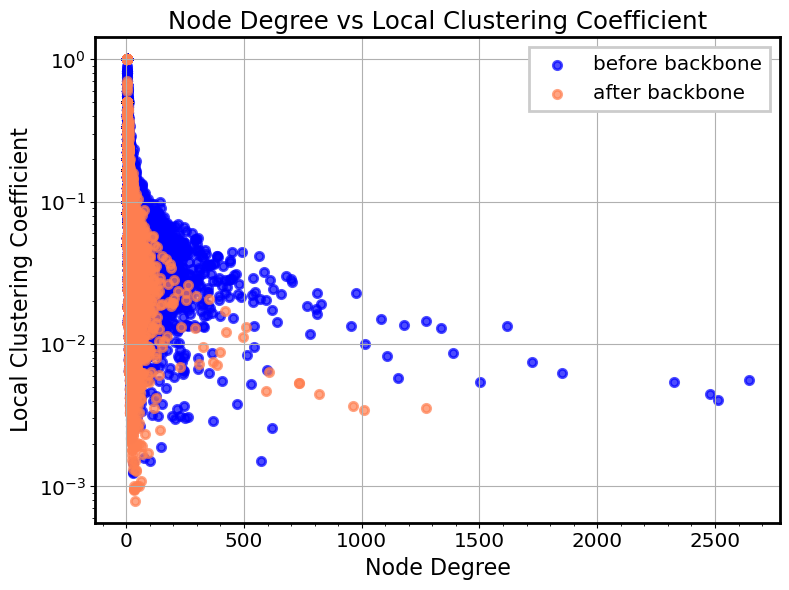

In [48]:
plot_degree_distribution(full_graph, full_graph_backbone, save=True)
plot_degree_vs_clustering(full_graph, full_graph_backbone, save=True)
#plot_shortest_path_length_distribution(full_graph, full_graph_backbone)

In [6]:
print("Before Backboning")
print(f"Average degree: {sum(dict(full_graph.degree()).values())/float(len(full_graph))}")
print(f"Global clustering: {nx.average_clustering(full_graph)}")

print("\nAfter Backboning")
print(f"Average degree: {sum(dict(full_graph_backbone.degree()).values())/float(len(full_graph_backbone))}")
print(f"Global clustering: {nx.average_clustering(full_graph_backbone)}")

Before Backboning
Average degree: 14.332601242768373
Global clustering: 0.08191456394352023

After Backboning
Average degree: 7.6792144026186575
Global clustering: 0.023542244050854064


Il valori di degree e global clustering diminuiscono dopo il backboning. Il risultato è atteso visto che sono diminuiti il numero di nodi si è quasi dimezzato e il numero di archi è diventato un quarto di quello originale. Infatti si può notare che l'**average degree** dopo il backboning è **circa la metà**, invece il **global clustering** è circa **un quarto**.

### Community dopo backboning

In [58]:
# Trasformo in grafici indiretti per poter applicare Louvain
full_graph_undirect = full_graph.to_undirected()
full_graph_backbone_undirect = full_graph_backbone.to_undirected()

In [69]:
from cdlib import algorithms, evaluation, ensemble

all_coms = []
all_scoring = []
for g in [full_graph_undirect, full_graph_backbone_undirect]:
    resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
    randomize = ensemble.BoolParameter(name="randomize")

    coms, scoring = ensemble.grid_search(graph=g, method=algorithms.louvain,
                                                     parameters=[resolution, randomize],
                                                     quality_score=evaluation.erdos_renyi_modularity,
                                                     aggregate=max)
    all_coms.append(coms)
    all_scoring.append(scoring)
    
    if g == full_graph_undirect: print("Before Backbone:")
    else: print("\nAfter Backbone:")
    print("# Communities:\n %s \nConfiguration: %s \nScoring: %s" %(len(coms.communities), coms.method_parameters, scoring))

Before Backbone:
# Communities:
 1795 
Configuration: {'weight': 'weight', 'resolution': 0.9, 'randomize': False} 
Scoring: FitnessResult(min=None, max=None, score=0.6240775375478625, std=None)

After Backbone:
# Communities:
 1315 
Configuration: {'weight': 'weight', 'resolution': 0.6, 'randomize': False} 
Scoring: FitnessResult(min=None, max=None, score=0.6458035636375232, std=None)


In [84]:
# Rimuove l'attributo 'communities' da tutti i nodi
for node in full_graph_backbone.nodes:
    if 'communities' in full_graph_backbone.nodes[node]:
        del full_graph_backbone.nodes[node]['communities']

## Inizializzazione opinioni
Purtroppo Reddit non permette l'accesso ai dati sui votanti dei post (upvotes e downvotes), non è possibile assegnare direttamente le opinioni a chi ha espresso il voto. L'unico modo per inferire le opinioni è usare i voti ricevuti nei post e commenti come proxy dell'opinione dell'autore.

- Se un utente riceve **molti upvotes** nei subreddit **conservatori**, probabilmente è **pro-Trump**.
- Se un utente riceve **molti upvotes** nei subreddit **democratici**, probabilmente è **pro-Biden**.
- Se un utente riceve **molti downvotes** nei **subreddit opposti**, significa che **l'opinione del post non è allineata a quel gruppo politico**.

Questo permette solo una inizializzazione grossolana per poter attivare il processo di diffusione studiato successivamente. 
Visto che per i commenti il ragionamento scritto sopra è meno evidente (per esempio un commento critico su un post favorevole ottiene voti contrari alla suo opinione reale), allora **il peso dei voti sui commenti è inferiore a quello sui posts**.

- Un'__opinione di 1__ indica supporto per __Trump__.
- Un'__opinione di 0__ indica supporto per __Biden/Harris__.

Gli utenti ricevono un punteggio in base ai voti dei loro post:

- Upvote su r/trump o r/conservative → aumenta supporto Trump
- Downvote su r/JoeBiden, r/KamalaHarris, r/liberal o r/democrats → aumenta supporto Trump
- Upvote su r/JoeBiden o r/KamalaHarris, r/liberal o r/democrats → aumenta supporto Biden/Kamala
- Downvote su r/trump o r/conservative → aumenta supporto Biden/Kamala

Il valore viene calcolato come: $ \frac{\text{supporto Trump} - \text{supporto Biden}}{\text{supporto totale}}$
Il risultato è nel'intervallo [-0.5, 0.5], quindi bisogna traslarlo di 0.5

In [32]:
def calculate_opinion(posts, comments, backbone_graph, post_weight=1.5, comment_weight=1.0):
    """Calcola l'opinione di ogni utente normalizzandola tra 0 e 1, correggendo il problema dei commenti."""
    user_support = {user: [0, 0] for user in backbone_graph}  # {utente: [supporto Trump, supporto Biden]}

    def process_vote(author, upvotes, downvotes, subreddit, weight):
        """Elabora voti con controlli su valori anomali."""
        if author not in backbone_graph:
            return  # Ignora utenti fuori dal backbone

        # Controllo per evitare valori anomali nei voti
        upvotes = max(0, upvotes)  # Evita valori negativi
        downvotes = max(0, downvotes)

        if subreddit in ["trump", "conservative"]:
            user_support[author][0] += upvotes * weight  # Upvotes → Pro-Trump
            user_support[author][1] += downvotes * weight  # Downvotes → Pro-Biden
        elif subreddit in ["JoeBiden", "KamalaHarris", "liberal", "democrats"]:
            user_support[author][1] += upvotes * weight  # Upvotes → Pro-Biden
            user_support[author][0] += downvotes * weight  # Downvotes → Pro-Trump

    # Processa i post con peso maggiore
    for post in posts:
        process_vote(post["author"], post.get("ups", 0), post.get("downs", 0), post["subreddit"], post_weight)
    
    # Processa i commenti con peso minore
    for comment in comments:
        process_vote(comment["author"], comment.get("ups", 0), comment.get("downs", 0), comment["subreddit"], comment_weight)

    # Calcolo dell'opinione finale normalizzando correttamente
    user_opinion = {}
    for user, (support_trump, support_biden) in user_support.items():
        total_support = support_trump + support_biden 
        if total_support > 0:   
            opinion = (support_trump - support_biden) / total_support  # Normalizza 
            user_opinion[user] = (opinion + 1) / 2  # Porta valori tra 0 e 1 (trasla di 0.5)
        else: user_opinion[user] = 0.5 # Neutrale se senza voti

    return user_opinion


def add_opinion_to_graph(G, user_opinion):
    """Aggiunge l'opinione degli utenti come attributo nel grafo."""
    for node in G.nodes():
        G.nodes[node]["opinion"] = user_opinion.get(node, 0.5)  # Default: neutrale (0.5)

In [33]:
# Calcola l'opinione degli utenti
user_opinion = calculate_opinion(all_posts, all_comments, full_graph_backbone)

add_opinion_to_graph(full_graph_backbone, user_opinion)

In [34]:
# Aggiorno il garfico salvato
nx.write_gexf(full_graph_backbone, os.path.join("graph","full_network_backbone_opinion.gexf"))

In [35]:
# Stampa solo i primi 5 nodi con i loro attributi
for node, data in itertools.islice(full_graph_backbone.nodes(data=True), 5):
    print(f"Nodo {node}: {data}")

print('\n')
# Stampa solo i primi 5 archi con i loro attributi
for edge in itertools.islice(full_graph_backbone.edges(data=True), 5):
    print(edge)

Nodo Instr-FTO: {'opinion': 1.0}
Nodo AutomaticDrop6236: {'opinion': 1.0}
Nodo Sufficient-Cat-5399: {'opinion': 1.0}
Nodo onearmedmonkey: {'opinion': 1.0}
Nodo Captainmanic: {'opinion': 1.0}


('Instr-FTO', 'AutomaticDrop6236', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'Sufficient-Cat-5399', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'onearmedmonkey', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'Captainmanic', {'weight': 2.0, 'subreddit': 'trump'})
('Instr-FTO', 'Silent_Spell_3415', {'weight': 3.0, 'subreddit': 'trump'})


### Visualizzazione

In [39]:
def plot_opinion_distribution(user_opinion, title="Distribuzione delle opinioni degli utenti", save=False, ax=None):
    """Crea un istogramma della distribuzione delle opinioni degli utenti."""
    if ax is None: fig, ax = plt.subplots()   
    
    opinions = list(user_opinion.values())

     # Creazione dell'istogramma
    counts, bins, patches = ax.hist(opinions, bins=20, edgecolor='black', log=True)

    # Colora le barre con una mappa di colori da blu (sinistra) a rosso (destra)
    cmap = plt.get_cmap("coolwarm")  # Blu → Rosso
    norm = plt.Normalize(vmin=0, vmax=1)  # Normalizza tra 0 e 1

    for patch, bin_left in zip(patches, bins[:-1]):
        color = cmap(norm(bin_left))  # Assegna il colore in base alla posizione
        patch.set_facecolor(color)

    ax.set_xlabel("Opinione")# (0 = pro-Biden, 1 = pro-Trump)")
    ax.set_ylabel("Numero di utenti")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    if save: plt.savefig(os.path.join("images", title))

    if ax is None: plt.show() # Serve per plot multipli

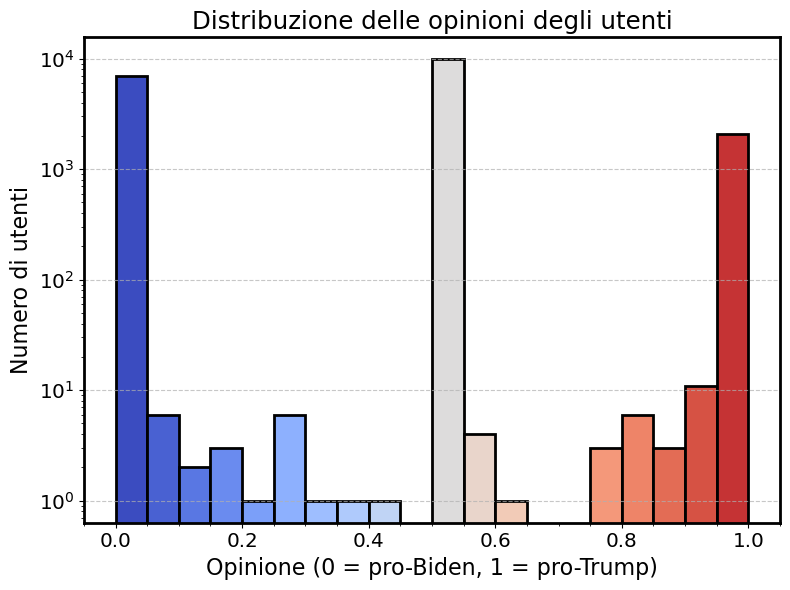

In [38]:
plot_opinion_distribution(user_opinion, save=True)

### Homophily

In [15]:
nx.attribute_assortativity_coefficient(full_graph_backbone, 'opinion')

0.7837777540869072

## Snapshot graphs

Salvo gli edges del nuovo grafo (dopo backboning), in modo da filtrare i collegamenti eliminati prima di creare gli snapshot

In [107]:
filtered_edges = set(zip(df_backbone["src"], df_backbone["trg"]))

In [215]:
# Creare i 6 snapshot settimanali
start_date = datetime(2024, 6, 22)
for i in range(6):
    end_date = start_date + timedelta(days=7)

    # Selezionare solo i commenti e post della settimana corrente
    week_comments = [c for c in all_comments if start_date <= c["created_utc"] < end_date]
    week_posts = [p for p in all_posts if start_date <= p["created_utc"] < end_date]

    # Creare il grafo settimanale
    week_graph = build_graph(week_comments, week_posts)

    # Applicare il filtraggio: rimuovere gli archi che non sono nel backbone
    for u, v in list(week_graph.edges()):
        if (u, v) not in filtered_edges:
            week_graph.remove_edge(u, v)

    # Dopo il filtraggio posso rimanere dei nodi senza collegamento
    degree = dict(week_graph.degree()) 
    zero_nodes = {node for node, deg in degree.items() if deg == 0}
    week_graph.remove_nodes_from(zero_nodes)

    # Aggiungere opinioni solo ai nodi rimasti
    add_opinion_to_graph(week_graph, user_opinion)

    # Salvare lo snapshot settimanale
    nx.write_gexf(week_graph, os.path.join("graph",f"network_week_{i+1}.gexf"))
    print(f"✔️ Snapshot {i+1} creato!")

    start_date = end_date  # Passa alla settimana successiva

✔️ Snapshot 1 creato!
✔️ Snapshot 2 creato!
✔️ Snapshot 3 creato!
✔️ Snapshot 4 creato!
✔️ Snapshot 5 creato!
✔️ Snapshot 6 creato!


Homophily (week 1) = 0.6919874978757923

Homophily (week 2) = 0.7273301325903838

Homophily (week 3) = 0.73468860474677

Homophily (week 4) = 0.7519772863590781

Homophily (week 5) = 0.7843498202206688

Homophily (week 6) = 0.8075126348582236



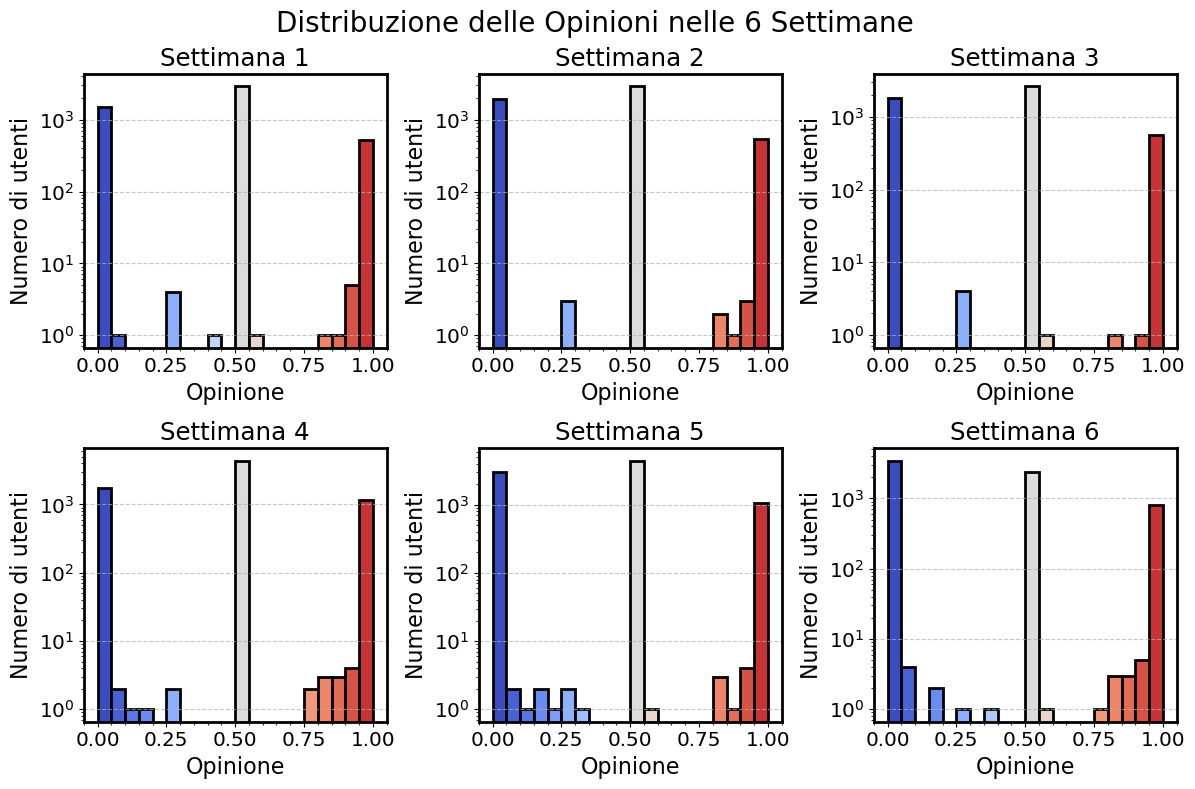

In [46]:
homophily = []

# Crea una figura con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()  # Converte la matrice 2x3 in un array per un facile accesso

for i in range(6):
    week_graph = nx.read_gexf(os.path.join("graph", f"network_week_{i+1}.gexf"))
    opinions_dict = {node: week_graph.nodes[node]["opinion"] for node in week_graph.nodes if "opinion" in week_graph.nodes[node]}
    
    # Disegnare il grafico nella cella corrispondente
    ax = axes[i]
    plot_opinion_distribution(opinions_dict, title=f"Settimana {i+1}", save=False, ax=ax)
    
    # Calcolare e stampare homophily
    homophily.append(nx.attribute_assortativity_coefficient(week_graph, 'opinion'))
    print(f"Homophily (week {i+1}) = {homophily[i]}\n")

# Aggiungere un titolo alla figura
fig.suptitle("Distribuzione delle Opinioni nelle 6 Settimane", fontsize=20)

# Regolare gli spazi tra i grafici
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale

# Salva l'immagine in un file
plt.savefig(os.path.join("images", "distribuzione_opinioni_settimane.png"))
plt.show()

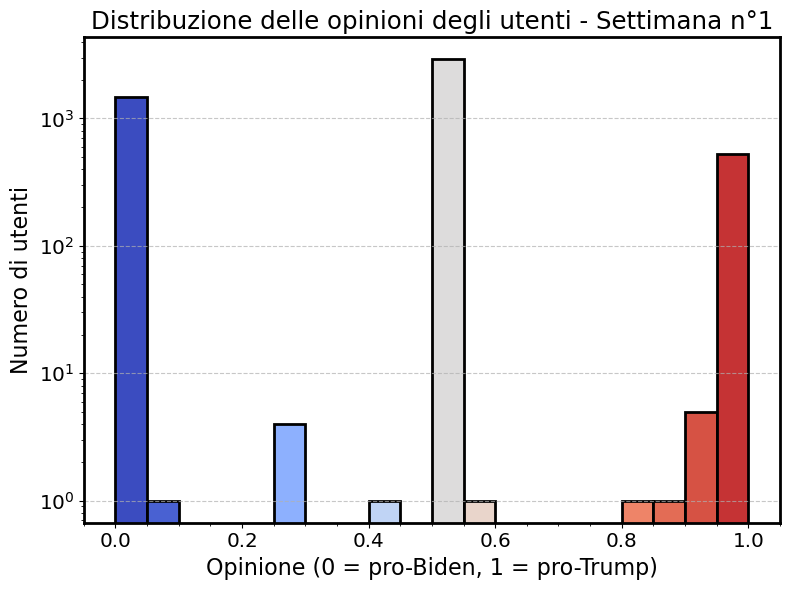

Homophily (week 1) = 0.6919874978757923



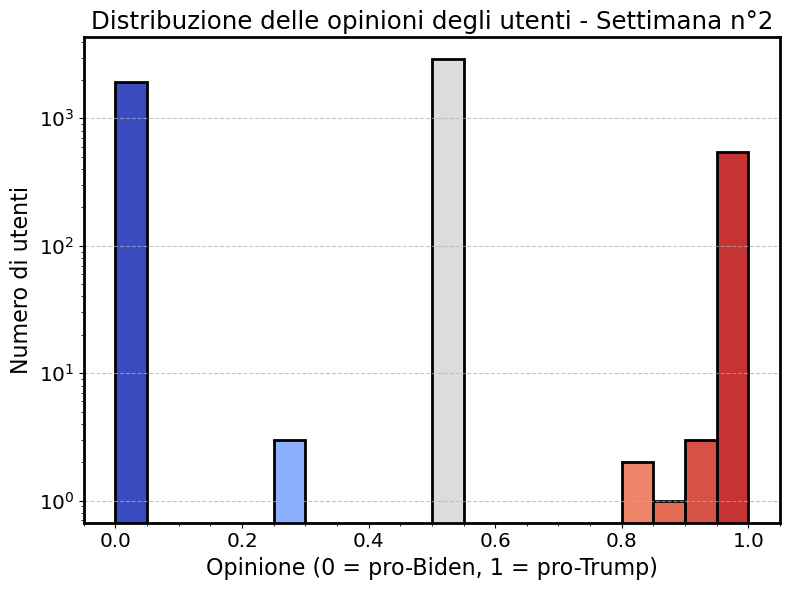

Homophily (week 2) = 0.7273301325903838



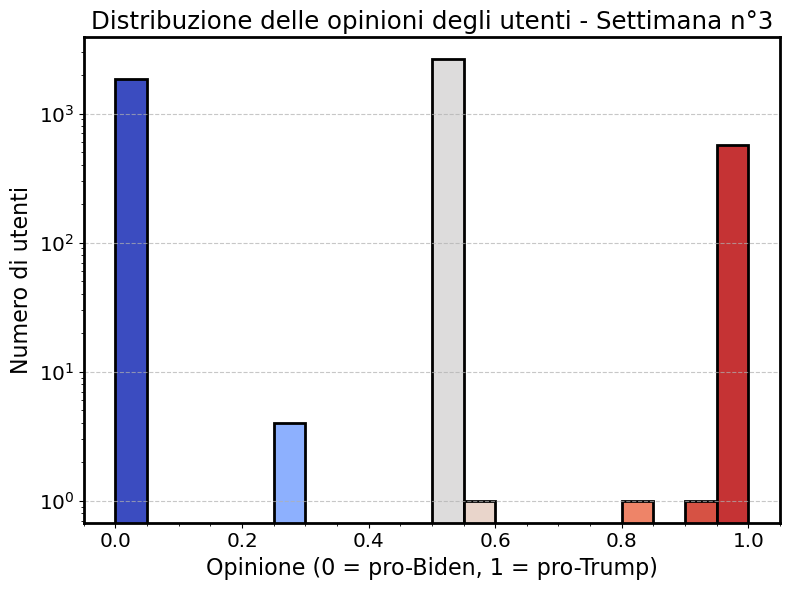

Homophily (week 3) = 0.73468860474677



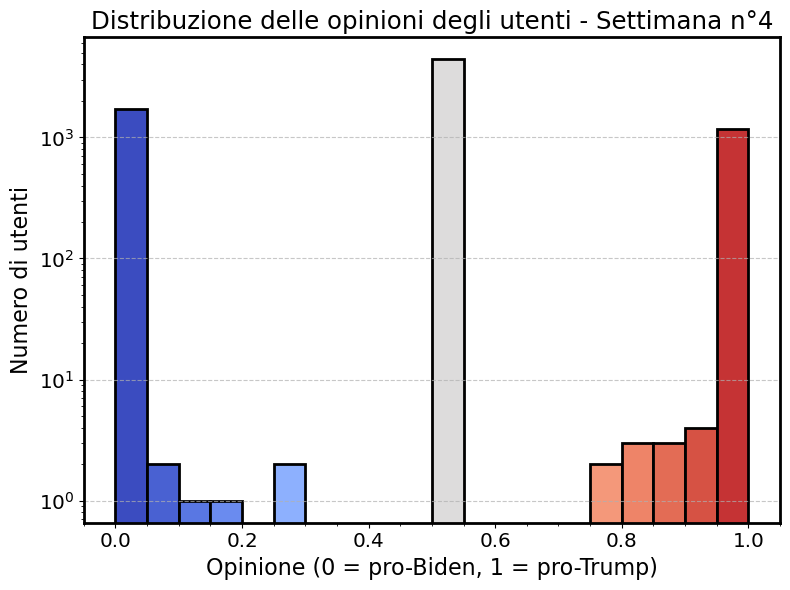

Homophily (week 4) = 0.7519772863590781



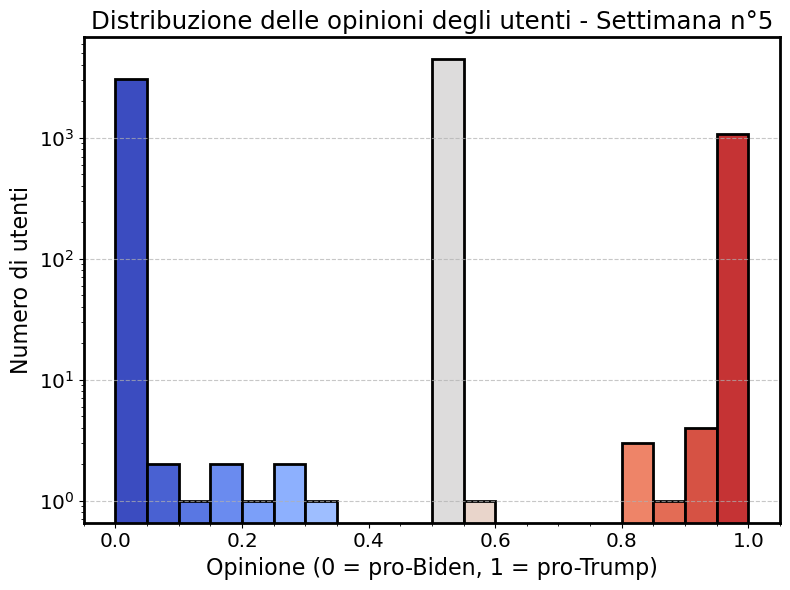

Homophily (week 5) = 0.7843498202206688



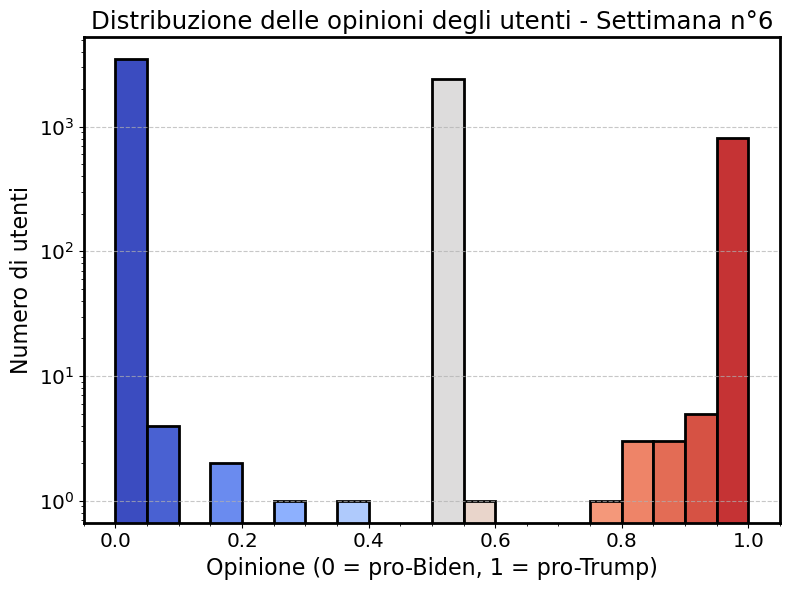

Homophily (week 6) = 0.8075126348582236



In [216]:
for i in range(6):
    week_graph = nx.read_gexf(os.path.join("graph",f"network_week_{i+1}.gexf"))
    opinions_dict = {node: week_graph.nodes[node]["opinion"] for node in week_graph.nodes if "opinion" in week_graph.nodes[node]}
    plot_opinion_distribution(opinions_dict, title=f"Distribuzione delle opinioni degli utenti - Settimana n°{i+1}", save=True)
    print(f"Homophily (week {i+1}) = {nx.attribute_assortativity_coefficient(week_graph, 'opinion')}\n")

Nella quarta settimana che inizia il 13 Luglio 2024 (giorno dell'attentato a Trump), si può notare un aumento di opinioni favorevoli a Trump e un aumento dell'homophily. Il secondo giorno della quinta settimana, in particolare il 21 Luglio 2024, Kamala Harris entra come nuova candidata, si può notare un aumento dell'opinione verso i liberali (con un picco massimo nella sesta settimana).
Inoltre si può notare un andamento monotonicamente crescente dell'homophily, probabilmente dovuto all'aumento di polarizzazione successivo a questi due eventi.

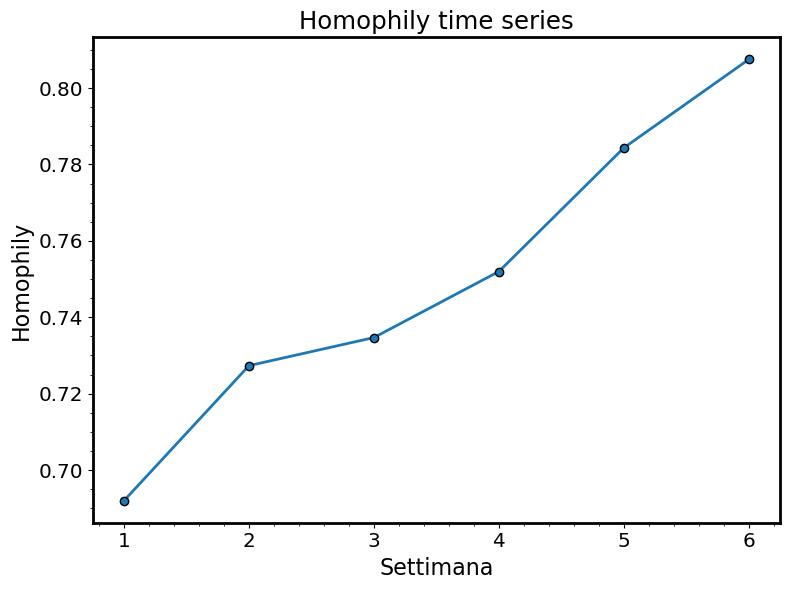

In [47]:
plt.plot(range(1,7), homophily, marker='o', markeredgecolor='black')
plt.title("Homophily time series")
plt.xlabel("Settimana")
plt.ylabel("Homophily")

plt.savefig(os.path.join("images", "homophily_timeseries.png"))